<a href="https://colab.research.google.com/github/scjjb/MIDOG_Domain_Adaptation/blob/main/MIDOG_Demo_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation 
Install required packages, import packages in to the notebook, and prepare WSIs into usable segments

In [1]:
## Install required packages.
## The exact versions used are detailed in the requirements.txt file.

## U-Net model architecture
!pip install segmentation_models_pytorch

## RetinaNet packages
!pip install -U object-detection-fastai
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

## To evaluate Frechet Inception Distances
!pip install pytorch-fid

## Get code from GitHub
!git clone https://github.com/scjjb/MIDOG_Domain_Adaptation
!git clone https://github.com/scjjb/pneumothorax_segmentation

## Required packages for CycleGAN
!pip install dominate
!pip install visdom

## Get CycleGAN code and select working directory 
%cd "/drive/MyDrive/MIDOG_Style_Transfer"
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
%cd pytorch-CycleGAN-and-pix2pix

     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 376 kB 56.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=adf0dcab7b06a1431d7dfcff4ccf88f900c1290d65320442fa47d773f44e840e
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1a22524d7e558fab2c16b110684250ed7ad3323ab842f50216de5d95c404ce48
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 316 kB 14.6 MB/s 
     |████████████████████████████████| 60.3 MB 76 kB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.wh

In [2]:
## Import required packages and functions

from MIDOG_Domain_Adaptation.code.data_funcs import get_bbox_df,train_test_split,folderise_crops_by_WSI_index
from MIDOG_Domain_Adaptation.code.segmentation_funcs import mask_segmentor

from MIDOG_Domain_Adaptation.code.segmentation_processing import preprocess_crops, get_model_predictions, add_bbox_to_map
from MIDOG_Domain_Adaptation.code.segmentation_modelling import create_data_loaders, train_one_epoch, metric, evaluate, F1_score_centered

from MIDOG_Domain_Adaptation.code.fastai_sampling import sample_selector
from MIDOG_Domain_Adaptation.code.fastai_output import get_prediction, F1Metric, F1_score

from MIDOG_Domain_Adaptation.code.get_predictions import get_default_prediction, get_cyclegan_prediction, get_nst_prediction, bootstrap_f1_scores


from google.colab import drive, files
import os
import random
import glob
from shutil import copy
import gc

import torch
from torchvision import transforms
import torchvision.models as models
import segmentation_models_pytorch

import numpy as np
import matplotlib.pyplot as plt

from pneumothorax_segmentation.unet_pipeline.Losses import ComboLoss 

from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBMetrics, PascalVOCMetric


In [4]:
## Mount google drive if using this for data storage
drive.mount('/drive')

Mounted at /drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
## Get dataset and generate 512x512 crops from the original WSIs

df = get_bbox_df()
df_train, df_test = train_test_split(df)
image_ids=list(df['file_name'].unique())
#mask_segmentor(image_ids,df,512,512,categories=["mitotic figure"],image_folder='/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/image_crops/')
#drive.flush_and_unmount() ##This is required when using mask_segmentor with Google Drive, otherwise Drive may not synchronise with new changes

## Train and save baseline model(s)

U-Net Segementation

only 1300 test images available


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 0, TRAIN LOSS: 3.100101505120595, VAL LOSS: 5.411074203491211, VAL F1: [0.0, 0, 0, 80]


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 1, TRAIN LOSS: 1.8389812918504078, VAL LOSS: 5.055552829742432, VAL F1: [0.0, 0, 0, 80]


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 2, TRAIN LOSS: 1.5888640590508778, VAL LOSS: 4.846757884979248, VAL F1: [0.0, 0, 0, 80]


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 3, TRAIN LOSS: 1.4533871408303578, VAL LOSS: 4.706209392547607, VAL F1: [0.0, 0, 0, 80]


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 4, TRAIN LOSS: 1.3420656009515126, VAL LOSS: 4.597459247589112, VAL F1: [0.623, 48, 25, 33]


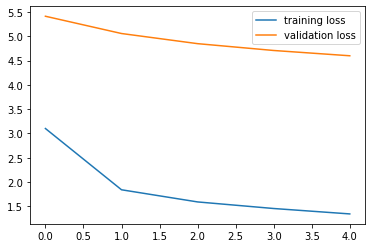

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test F1s:  []
train F1s:  []


In [ ]:
scanners = [[["Hamamatsu XR","Aperio CS"],["Hamamatsu S360"]]] ##This uses HXR,ACS for training, HS60 for validation

## Set detection parameters 
threshold=0.5
min_detection_dim=10

## Set training parameters
learning_rate=5e-5
gamma=0.9
max_epochs=5
description="colab_demo"

## Set data transforms. 
## train_transforms will only be used in training, not evaluation
## image_transforms will be used in training and evaluation 
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=90,translate=(0.1,0.1), scale=(0.9,1.1),shear=0.1)
])

image_transforms = transforms.Compose([
    transforms.ToTensor(),
])

## Training loop for each train,validation pair selected
F1scores=[]
for i in range(len(scanners)):
  train_scanners=scanners[i][0]
  valid_scanners=scanners[i][1]
  
  ## Model selection can be changed
  model = segmentation_models_pytorch.Unet(
      encoder_name='resnet152', 
      encoder_weights='imagenet', 
      classes=1, 
      activation=None,
  )

  ## Prepare data loaders with image crops 
  train_ids,valid_ids,test_ids = preprocess_crops(5000,1000,2000,train_scanners=train_scanners,valid_scanners=valid_scanners)  
  train_loader,valid_loader,test_loader = create_data_loaders(train_ids,valid_ids,test_ids=test_ids,image_transform=image_transforms,train_transform=train_transforms)

  optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=0.001)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(
  optimizer, milestones=[1,2,3,4,5,6,7,8,9,10], gamma=gamma)

  ## Weights of losses can be changed
  criterion = ComboLoss(**{'weights':{'bce':2, 'dice':1, 'focal':10}})
  
  train_losses=[]
  val_losses=[]
  train_f1s=[]
  val_f1s=[]
  best_f1_score=-1

  ## Training epoch loop
  for epoch in range(max_epochs):
      model.train()
      loss = train_one_epoch(train_loader, model, optimizer, criterion, batches_per_epoch=300)

      ## Evaluate loss and F1-score
      model.eval()
      with torch.no_grad():
        val_loss = evaluate(valid_loader, model, metric=criterion)
        scheduler.step()
        valid_preds,valid_masks,valid_images=get_model_predictions(model,valid_loader,device)
        bboxs = add_bbox_to_map(valid_preds,threshold=threshold,min_dim=min_detection_dim,return_images=False)
        true_bboxs=add_bbox_to_map(valid_masks,threshold=threshold,return_images=False)
        f1_score=F1_score_centered(bboxs,true_bboxs)
        val_f1s.append(f1_score[0])
        del bboxs, true_bboxs, valid_masks, valid_images ##RAM usage is too high without deletion
        gc.collect()


        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL LOSS: {val_loss}, VAL F1: {f1_score}")
        model_path=f"/tmp/bst_model_{np.round(val_loss,4)}.bin"


        ## Below can be used for checkpointing the best model 
        if f1_score[0] > best_f1_score:
          best_f1_score = f1_score[0]
          best_model = model_path
        
        train_losses.append(loss)
        val_losses.append(val_loss)
  

  ## Save model
  train_names=("").join([name[-2:] for name in train_scanners])
  valid_names=("").join([name[-2:] for name in valid_scanners])
  torch.save(model, "/drive/MyDrive/MIDOG_Style_Transfer/models/"+'UNet_train'+train_names+'_valid'+valid_names+'_'+description)


  ## Plot loss curves
  model.eval()
  f = plt.figure()
  plt.plot(train_losses,label="training loss")
  plt.plot(val_losses,label="validation loss")
  plt.legend()
  plt.show()
  val_scanner=valid_scanners[0][0]+valid_scanners[0][-3:]
  val_scanner=val_scanner.replace(" ","")
  f.savefig(f"UNet_{val_scanner}_losses_{description}.png")
  files.download(f"UNet_{val_scanner}_losses_{description}.png") 

  ## Evaluation code below is superfluous when training a big model but useful when experimenting
  # f = plt.figure()
  # #plt.plot(train_f1s,label="training F1")
  # plt.plot(val_f1s,label="validation F1")
  # plt.legend()
  # plt.show()
  # val_scanner=valid_scanners[0][0]+valid_scanners[0][-3:]
  # val_scanner=val_scanner.replace(" ","")
  # f.savefig(f"UNet_{val_scanner}_F1_{description}.png")
  # files.download(f"UNet_{val_scanner}_F1_{description}.png") 

  # #model = torch.load(best_model)
  # train_preds,train_masks,train_images=get_model_predictions(model,train_loader,device,max_batches=125)
  # train_bboxs = add_bbox_to_map(train_preds,threshold=threshold,min_dim=min_detection_dim,return_images=False)
  # train_true_bboxs=add_bbox_to_map(train_masks,threshold=threshold,return_images=False)
  # train_f1_score=F1_score_centered(train_bboxs,train_true_bboxs)
  # print("train F1 score: ",train_f1_score)
  # train_f1s.append(train_f1_score[0])
  # del train_bboxs, train_true_bboxs, train_masks, train_images ##RAM usage is too high without deletion
  # gc.collect()


  # test_preds,test_masks,test_images=get_model_predictions(model,test_loader,device)
  # bboxs = add_bbox_to_map(test_preds,return_images=False)
  # true_bboxs=add_bbox_to_map(test_masks,return_images=False)
  # f1_score=F1_score_centered(bboxs,true_bboxs)
  # print("test F1 score: ",f1_score)
  # F1scores.append(f1_score[0])
  # del bboxs, true_bboxs, test_masks, test_images ##RAM usage is too high without deletion
  # gc.collect()

print("test F1s: ",F1scores)
print("train F1s: ",train_f1s)

RetinaNet

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Empty DataFrame
Columns: [F1_mitot, TP_mitot, FP_mitot, FN_mitot, F1_hneg, TP_hneg, FP_hneg, FN_hneg]
Index: []


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-hard negative,AP-mitotic figure,time
0,0.938038,0.453430,0,0.100816,0.352614,0,0,09:58
1,0.599494,0.291445,0.129346,0.035471,0.255974,0.166737,0.091954,04:10
2,0.576852,0.278711,0.147239,0.039476,0.239236,0.294478,0.000000,03:49
3,0.505863,0.188715,0.263660,0.042079,0.146636,0.000000,0.527321,03:48
4,0.498951,0.222933,0.401048,0.045629,0.177304,0.000000,0.802096,03:46
5,0.409508,0.278051,0.199001,0.069576,0.208475,0.285502,0.112500,03:55
6,0.420743,0.225630,0.351003,0.046852,0.178779,0.440366,0.261640,03:59
7,0.366320,0.263747,0.281527,0.044203,0.219544,0.303272,0.259783,03:58
8,0.327580,0.199866,0.366870,0.048853,0.151014,0.359808,0.373932,03:54
9,0.345308,0.232962,0.408773,0.060409,0.172553,0.316359,0.501187,03:55


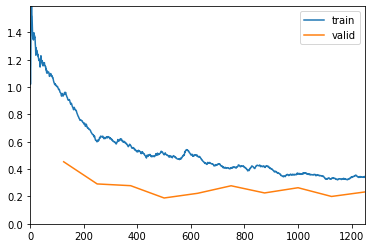

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

   F1_mitot  TP_mitot  FP_mitot  FN_mitot  F1_hneg  TP_hneg  FP_hneg  FN_hneg
0     0.000       0.0       0.0       8.0    0.000      0.0      0.0     12.0
1     0.261       3.0      12.0       5.0    0.147      8.0     89.0      4.0
2     0.000       0.0       0.0       8.0    0.289     13.0     63.0      1.0
3     0.164       6.0      60.0       1.0    0.000      0.0      5.0     14.0
4     0.308       4.0      18.0       0.0    0.000      0.0      0.0     12.0
5     0.182       1.0       1.0       8.0    0.214     11.0     76.0      5.0
6     0.286       1.0       1.0       4.0    0.075      4.0     91.0      8.0
7     0.400       2.0       4.0       2.0    0.139      7.0     85.0      2.0
8     0.727       4.0       0.0       3.0    0.268     11.0     53.0      7.0
9     0.727       4.0       1.0       2.0    0.164      6.0     55.0      6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

train set F1 score: [0.604, 48, 47, 16, 0.086, 44, 892, 47]


  0%|          | 0/1000 [00:00<?, ?it/s]

test set F1 score: [0.696, 88, 26, 51, 0.275, 111, 535, 51]
train F1 scores:  [0.604]
test F1 scores:  [0.696]


In [ ]:
scanners = [["Hamamatsu XR,Aperio CS","Hamamatsu S360"]]

## Prepare encoder
backbone_model = models.resnet101
pre_trained_on_imagenet = True
encoder = create_body(backbone_model, pre_trained_on_imagenet, -2)

## Set training data transforms and bounding box anchor parameters
transforms = get_transforms(do_flip=True,flip_vert=True,max_rotate=90,max_zoom=1.1,max_lighting=0.2,
                      max_warp=0.2,p_affine=0.75,p_lighting=0.75)
scales = [2] ; ratios=[1] ; sizes=[(64,64)]
anchors = create_anchors(sizes, ratios, scales)

## Prepare loss function
loss_function = "FocalLoss"
if loss_function == "FocalLoss":
    crit = RetinaNetFocalLoss(anchors)

## Set remaining architecture parameters
channels = 128 ##Dimension of dense layers
final_bias = -4 ##Bias for the dense layers
n_conv = 3 ##Number of hidden layers

## Set number of training epochs and learning rate
frozen_cycles_epochs=0
frozen_max_learning_rate=1e-5
unfrozen_cycles_epochs = 10
unfrozen_max_learning_rate = 1e-4

batch_size = 12
patch_size = 512

## Name the model
description="colab_demo"

F1scores=[]
F1scores_train=[]
for i in range(len(scanners)):
  train_scanners=scanners[i][0]
  valid_scanners=scanners[i][1]
  dataset=sample_selector(df_train,1500,500,batch_size,transforms,patch_size=512,random_seed=201,train_scanner = train_scanners, val_scanner = valid_scanners,normalise=False)
  dataset_backwards=sample_selector(df_train,100,1000,batch_size,transforms,patch_size=512,random_seed=201,train_scanner = train_scanners,val_scanner = train_scanners, normalise=False,testdataframe=df_test)
  dataset_test=sample_selector(df_train,100,1000,batch_size,transforms,patch_size=512,random_seed=201,train_scanner = train_scanners, val_scanner = valid_scanners,normalise=False,testdataframe=df_test)
  encoder = create_body(backbone_model, pre_trained_on_imagenet, -2)

  model = RetinaNet(encoder, n_classes=dataset.train_ds.c, 
                  n_anchors=len(scales) * len(ratios), 
                  sizes=[size[0] for size in sizes], 
                  chs=channels, # number of hidden layers for the classification head
                  final_bias=final_bias, # Bias for the fully connected layers
                  n_conv=n_conv # Number of hidden layers
                  )
  
  voc = PascalVOCMetric(anchors, patch_size, [str(i) for i in dataset.train_ds.y.classes[1:]])


  learn = Learner(dataset, model, loss_func=crit, 
                callback_fns=[BBMetrics, ShowGraph],
                metrics=[voc]
               )
  
  learn.model_dir="/drive/MyDrive/MIDOG_Style_Transfer/models"

  learn.anchors = anchors

  learn.fit_one_cycle(frozen_cycles_epochs, frozen_max_learning_rate, 
                    callbacks = [F1Metric(learn)] 
                    )

  learn.unfreeze()

  ## For early stopping, add callback EarlyStoppingCallback(learn=learn, monitor='valid_loss', min_delta=0.01, patience=2)
  learn.fit_one_cycle(unfrozen_cycles_epochs, unfrozen_max_learning_rate, 
                    callbacks = [F1Metric(learn)] 
                    )

  train_names=("").join([name[-2:] for name in train_scanners.split(",")])
  valid_names=("").join([name[-2:] for name in valid_scanners.split(",")])
  learn.save('RetinaNet_train'+train_names+'_valid'+valid_names+'_'+description);
  
  learn.data=dataset_backwards
  pred_df, true_df = get_prediction(learn,anchors,show_img=False,cnt=1000)
  F1score_train= F1_score(pred_df,true_df)
  print("train set F1 score: "+str(F1score_train))
  F1scores_train.append(F1score_train[0])

  learn.data=dataset_test
  pred_df, true_df = get_prediction(learn,anchors,show_img=False,cnt=1000)
  F1score= F1_score(pred_df,true_df)
  print("test set F1 score: "+str(F1score))
  F1scores.append(F1score[0])

print("train F1 scores: ",F1scores_train)
print("test F1 scores: ",F1scores)



## Train CycleGAN

In [ ]:
## This CycleGAN implementation requires the training data to be in folders called "trainA" and "trainB" for the different domains
!python train.py --dataroot ./datasets/MIDOG_60XR_big --name colab_demo_cyclegan --model cycle_gan --crop_size 512 --load_size 512 --batch_size 1 --n_epochs 3 --n_epochs_decay 0 --save_epoch_freq 1 --display_id -1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 512                           	[default: 256]
                 dataroot: ./datasets/MIDOG_60XR_big     	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest           

In [ ]:
##continue training as previous run terminated early 
!python train.py --dataroot ./datasets/MIDOG_60XR_big --name colab_demo_cyclegan --model cycle_gan --crop_size 512 --load_size 512 --batch_size 1 --n_epochs 3 --n_epochs_decay 0 --continue_train --epoch_count 3 --save_epoch_freq 1 --display_id -1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: True                          	[default: False]
                crop_size: 512                           	[default: 256]
                 dataroot: ./datasets/MIDOG_60XR_big     	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: 

## Evaluate CycleGAN Epochs

In [ ]:
## Find all available images for each scanner

all_image_ids=[]
for root,_,files in os.walk("/drive/MyDrive/MIDOG_Challenge_JJB/image_crops/"):
  all_image_ids.extend(files)
HXR_ids=[id for id in all_image_ids if int(id[:3])<51] 
H60_ids=[id for id in all_image_ids if 50<int(id[:3])<101] 
ACS_ids=[id for id in all_image_ids if 100<int(id[:3])] 

In [ ]:
## Select 500 crops from each scanner for consistent comparison across CycleGAN epochs


images_per_folder=500


unseen_ids=random.sample(H60_ids,images_per_folder)
seen_ids=random.sample(HXR_ids,images_per_folder)

unseen_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/MIDOG_60XR_big/testA/"
seen_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/MIDOG_60XR_big/FrechetReals/"


##break if folders currently occupied
for _,_,files in os.walk(unseen_folder):
  for file in files:
    raise Exception("Files in unseen folder")

for _,_,files in os.walk(seen_folder):
  for file in files:
    raise Exception("Files in seen folder")


##Clear out the seen folder 
if os.path.isdir(seen_folder):
  files = glob.glob(seen_folder+"*")
  for file in files:
    os.remove(file)  

for image in unseen_ids:
  copy("/drive/MyDrive/MIDOG_Challenge_JJB/image_crops/"+image[:3]+"/"+image, unseen_folder+image ) 

for image in seen_ids:
  copy("/drive/MyDrive/MIDOG_Challenge_JJB/image_crops/"+image[:3]+"/"+image,seen_folder+image )





In [ ]:
## Baseline Score
fake_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/MIDOG_60XR_big/testA/"
real_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/MIDOG_60XR_big/FrechetReals/"
!python -m pytorch_fid {fake_folder} {real_folder} --device cuda:0

## Score at different epochs of CycleGAN
test_epochs=[1,2,3] 
for test_epoch in test_epochs:
  %run test.py --dataroot ./datasets/MIDOG_60XR_big --name colab_demo_cyclegan --model cycle_gan --epoch {test_epoch} --load_size 512 --crop_size 512 --num_test 500 --batch_size 4

  fake_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/results/colab_demo_cyclegan/test_"+str(test_epoch)+"/images/"
  real_folder="/drive/MyDrive/MIDOG_Style_Transfer/pytorch-CycleGAN-and-pix2pix/datasets/MIDOG_60XR_big/FrechetReals/"

  ##delete any that aren't fakeB
  files = glob.glob(fake_folder+"*")
  for file in files:
    if file[-11:]!="_fake_B.png":
      os.remove(file)

  !python -m pytorch_fid {fake_folder} {real_folder} --device cuda:0

100% 10/10 [00:03<00:00,  3.12it/s]
100% 10/10 [00:03<00:00,  2.78it/s]
FID:  59.265835953593296
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 4                             	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 512                           	[default: 256]
                 dataroot: ./datasets/MIDOG_60XR_big     	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 1                             	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from ./checkpoints/colab_demo_cyclegan/1_net_G_A.pth
loading the model from ./checkpoints/colab_demo_cyclegan/1_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
-----------------------------------------------
creating web directory ./results/colab_demo_cyclegan/test_1
processing (0000)-th image... ['./datasets/MIDOG_60XR_big/testA/051_x0_y3584.tiff']
processing (0005)-th image... ['./datasets/MIDOG_60XR_big/testA/051_x3584_y0.tiff']
processing (0010)-th image... ['./datasets/MIDOG_60XR_big/testA/051_x6144_y4096.tiff']
processing (0015)-th image... ['./datasets/MIDOG_60XR_big/testA/052_x4608_y4096.tiff']
processing (0020)-th image... ['./datasets/MIDOG_60XR_big/testA/053_x2048_y3072.tiff']
processing (0025)-th image... ['./datasets/MIDOG_60XR_big/testA/053_x512_y0

Summary: 

|Epoch | FID score |
| ----------- | ----------- |
| 0 | 59.2658 |
| 1 | 49.3845 |
| 2 | 47.0828 |
| 3 | 47.0826 |

In previous experiments, the FID score was minimised around epochs 5-8, then began to increase as the CycleGAN began to overfit the data. This may be improved using learning rate decay, but this has not been thoroughly investigated. 

## Apply CycleGAN to all images




In [ ]:
## Test data needs to be in folders called "testA" and "testB"
## We're only interested in stylising from domain A, so will put few images in testB folder. 
!python test.py --dataroot ./datasets/MIDOG_60XR_big --name colab_demo_cyclegan --model cycle_gan --epoch 3 --load_size 512 --crop_size 512 --num_test 6560 --batch_size 4


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 4                             	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 512                           	[default: 256]
                 dataroot: ./datasets/MIDOG_60XR_big     	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 3                             	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
          

In [ ]:
## Google drive can't handle this many files in the same directory very well, so we compartmentalise
folderise_crops_by_WSI_index('test_3','colab_demo_cyclegan')

## This forces the changes in folderisation to happen before we continue
drive.flush_and_unmount()

## Evaluate Models - U-Net

U-Net without style transfer

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

model = torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'UNet_train'+train_names+'_valid'+valid_names+'_'+description)
model.eval()

bboxs,true_bboxs=get_default_prediction(model,'unet',train_scanners,valid_scanners=valid_scanners,max_patches=10000,evaldomain='valid',evalset='both')

print("Overall F1 score, TP, FP, FN: ",F1_score_centered(bboxs,true_bboxs))
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=10000)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),", ",round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

only 5260 validation images available
only 1300 test images available
total evaluation patches:  6560


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Overall F1 score, TP, FP, FN:  [0.586, 314, 163, 280]


  0%|          | 0/10000 [00:00<?, ?it/s]

Boostrapping mean:  0.5858072 
Bootstrapping standard deviation:  0.018226201693166896
95% Confidence interval:  0.5501 ,  0.6215


U-Net with Neural Style Transfer

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

model = torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'UNet_train'+train_names+'_valid'+valid_names+'_'+description)
model.eval()

bboxs,true_bboxs=get_nst_prediction(model,'unet',train_scanners,valid_scanners,max_patches=10,evalset='train')
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=100)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

  0%|          | 0/2 [00:00<?, ?it/s]

Rolling F1-score:  [0.0, 0, 1, 0]


  0%|          | 0/100 [00:00<?, ?it/s]

0.0
0.0
Confidence interval:  0.0 0.0


U-Net with CycleGAN

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

model = torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'UNet_train'+train_names+'_valid'+valid_names+'_'+description)
model.eval()


## get_cyclegan_prediction is configured to get image crops after folderise_crops_by_WSI_index has been run
## For any other folderisation, pass in functions image_name_func and mask_name_func to find folders for stylised images and ground-truth mask crops
bboxs,true_bboxs=get_cyclegan_prediction(model,'unet',train_scanners,valid_scanners,'colab_demo_cyclegan','test_3',max_patches=10000)
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=10000)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),", ",round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

images found:  6560


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Boostrapping mean:  0.46811179999999997 
Bootstrapping standard deviation:  0.016659840958424536
95% Confidence interval:  0.4355 ,  0.5008


## Evaluate Models - RetinaNet

RetinaNet without style transfer

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

backbone_model = models.resnet101
pre_trained_on_imagenet = True
encoder = create_body(backbone_model, pre_trained_on_imagenet, -2)

scales = [2] ; ratios=[1] ; sizes=[(64,64)]
model=RetinaNet(encoder, n_classes=3,n_anchors=len(scales) * len(ratios),sizes=[size[0] for size in sizes],chs=128,final_bias=-4,n_conv=3)
model.load_state_dict(torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'RetinaNet_train'+train_names+'_valid'+valid_names+'_'+description+'.pth')['model'],strict=True)
model.to(device)
model.eval()

bboxs,true_bboxs=get_default_prediction(model,'retinanet',train_scanners,valid_scanners=valid_scanners,max_patches=100,evaldomain='train',
                                        evalset='train',anchors = create_anchors(sizes, ratios, scales))
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=100)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),", ",round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

total evaluation patches:  100


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Boostrapping mean:  0.6223299999999999 
Bootstrapping standard deviation:  0.13346902674403524
95% Confidence interval:  0.3607 ,  0.8839


RetinaNet with Neural Style Transfer

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

backbone_model = models.resnet101
pre_trained_on_imagenet = True
encoder = create_body(backbone_model, pre_trained_on_imagenet, -2)

scales = [2] ; ratios=[1] ; sizes=[(64,64)]
model=RetinaNet(encoder, n_classes=3,n_anchors=len(scales) * len(ratios),sizes=[size[0] for size in sizes],chs=128,final_bias=-4,n_conv=3)
model.load_state_dict(torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'RetinaNet_train'+train_names+'_valid'+valid_names+'_'+description+'.pth')['model'],strict=True)
model.to(device)
model.eval()

bboxs,true_bboxs=get_nst_prediction(model,'retinanet',train_scanners,valid_scanners,max_patches=300,evalset='train',anchors = create_anchors(sizes, ratios, scales))
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=100)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),", ",round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

  0%|          | 0/38 [00:00<?, ?it/s]

Rolling F1-score:  [0.4, 8, 5, 19]


  0%|          | 0/100 [00:00<?, ?it/s]

Boostrapping mean:  0.40399 
Bootstrapping standard deviation:  0.09097356704010237
95% Confidence interval:  0.2257 ,  0.5823


RetinaNet with CycleGAN

In [ ]:
description = "colab_demo"
train_scanners=["Hamamatsu XR","Aperio CS"]
valid_scanners=["Hamamatsu S360"]

train_names=("").join([name[-2:] for name in train_scanners])
valid_names=("").join([name[-2:] for name in valid_scanners])

backbone_model = models.resnet101
pre_trained_on_imagenet = True
encoder = create_body(backbone_model, pre_trained_on_imagenet, -2)

scales = [2] ; ratios=[1] ; sizes=[(64,64)]
model=RetinaNet(encoder, n_classes=3,n_anchors=len(scales) * len(ratios),sizes=[size[0] for size in sizes],chs=128,final_bias=-4,n_conv=3)
model.load_state_dict(torch.load("/drive/MyDrive/MIDOG_Style_Transfer/models/"+'RetinaNet_train'+train_names+'_valid'+valid_names+'_'+description+'.pth')['model'],strict=True)
model.to(device)
model.eval()

## get_cyclegan_prediction is configured to get image crops after folderise_crops_by_WSI_index has been run
## For any other folderisation, pass in functions image_name_func and mask_name_func to find folders for stylised images and ground-truth mask crops
bboxs,true_bboxs=get_cyclegan_prediction(model,'retinanet',train_scanners,valid_scanners,'colab_demo_cyclegan','test_3',max_patches=10000,anchors = create_anchors(sizes, ratios, scales))
F1_scores=bootstrap_f1_scores(bboxs,true_bboxs,bootstraps=10000)
print("Boostrapping mean: ",np.mean(F1_scores),"\nBootstrapping standard deviation: ",np.std(F1_scores))
print("95% Confidence interval: ",round(np.mean(F1_scores)-1.96*np.std(F1_scores),4),", ",round(np.mean(F1_scores)+1.96*np.std(F1_scores),4))

images found:  6560


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Boostrapping mean:  0.5803965999999999 
Bootstrapping standard deviation:  0.01722114132222367
95% Confidence interval:  0.5466 ,  0.6142
